In [13]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

from model.fgn import fractional_gaussian_covariance_series
from copulas.visualization import compare_3d

class FBm():

    def generate_gaussian_fBm(self, H1: float, H2: float, corr:float, size: int, drifts: list = [0.0, 0.0]) -> np.ndarray:

        means = np.zeros(2*size)     
        means[0:size] = means[0:size] + drifts[0]
        means[size:] = means[size:] + drifts[1]
                         
        result = np.random.multivariate_normal(means, 
                                               fractional_gaussian_covariance_series(size, H1, H2, corr))
        ts = np.ndarray((2, size))
        ts[0] = result[0:size]
        ts[1] = result[size:]

        return np.cumsum(np.insert(ts, 0, 0, axis=1), axis=1) 
    
    def hurst(self, X):

        X = np.array(X)
        N = X.size
        T = np.arange(1, N + 1)
        Y = np.cumsum(X)
        Ave_T = Y / T

        S_T = np.zeros(N)
        R_T = np.zeros(N)

        for i in range(N):
            S_T[i] = np.std(X[:i + 1])
            X_T = Y - T * Ave_T[i]
            R_T[i] = np.ptp(X_T[:i + 1])

        R_S = R_T / S_T
        R_S = np.log(R_S)[1:]
        n = np.log(T)[1:]
        A = np.column_stack((n, np.ones(n.size)))
        [m, c] = np.linalg.lstsq(A, R_S)[0]
        H = m
        return H

[0.01666666666666667, -0.05633333333333335]


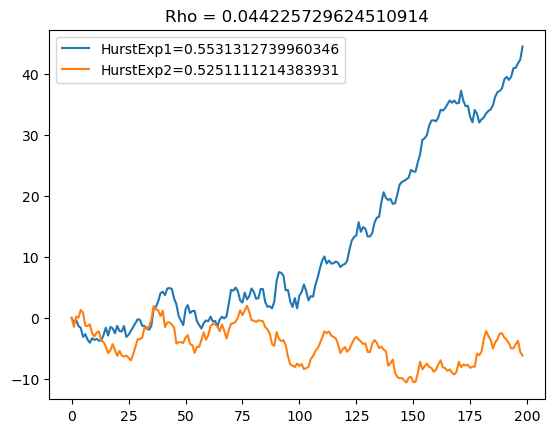

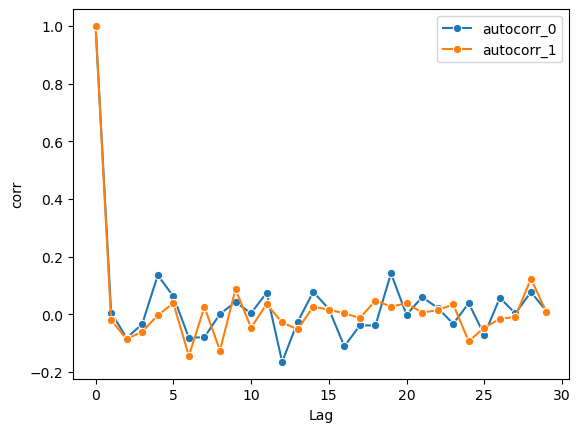

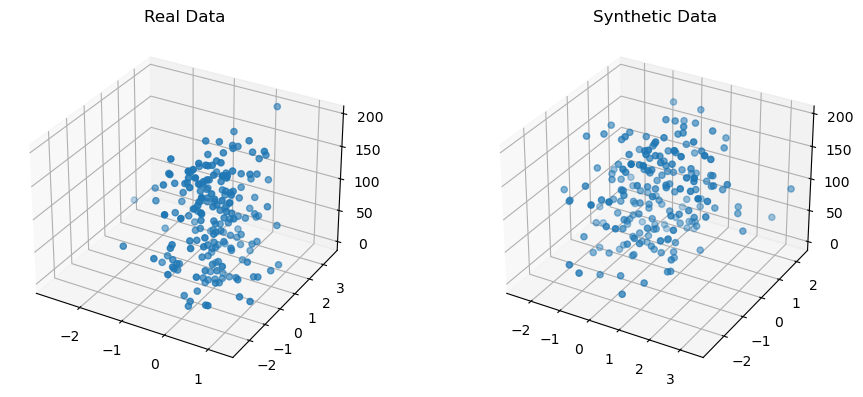

In [26]:
m6 = pd.read_csv('./data/assets_m6.csv')
m6_assets = pd.DataFrame()

m6_subset = pd.DataFrame()
for sym in ['GSG','IXN']: 
    m6_subset[sym] = m6[m6['symbol'] == sym]['price'].values

mean0 = m6_subset['GSG'].diff().dropna().mean()
mean1 = m6_subset['IXN'].diff().dropna().mean()
rho = np.corrcoef(m6_subset['GSG'].diff().dropna(), m6_subset['IXN'].diff().dropna())[0][1]

print([mean0, mean1])

fbm = FBm()
H1 = fbm.hurst(m6_subset['GSG'].diff().dropna().values)
H2 = fbm.hurst(m6_subset['IXN'].diff().dropna().values)

size = len(m6_subset) - 1

ts = fbm.generate_gaussian_fBm(H1, H2, rho, size, [mean0, mean1]) 
#ts = fBms #+ constant
                                          
plt.plot(ts[0], label=f"HurstExp1={H1}")
plt.plot(ts[1], label=f"HurstExp2={H2}")
plt.title(f"Rho = {rho}")
plt.legend()
plt.show()

autocorr_df = pd.DataFrame()
autocorr_df['decay_0'] = np.diff(ts[0])
autocorr_df['decay_1'] = np.diff(ts[1])
decay_func = lambda S, _range: [S.apply(abs).autocorr(lag=Lag) for Lag in _range]

sns.lineplot(data=decay_func(autocorr_df['decay_0'], range(0, 30)), label='autocorr_0', marker='o')
sns.lineplot(data=decay_func(autocorr_df['decay_1'], range(0, 30)), label='autocorr_1', marker='o')
plt.xlabel('Lag')
plt.ylabel('corr')
plt.show()

three_df = pd.DataFrame() 
three_df['x'] = np.diff(ts[0])
three_df['y'] = np.diff(ts[1])
three_df['z'] = range(size)

orig_three_df = pd.DataFrame()
orig_three_df['x'] = m6_subset['GSG'].diff().dropna().values
orig_three_df['y'] = m6_subset['IXN'].diff().dropna().values
orig_three_df['z'] = range(len(m6_subset)-1)

compare_3d(orig_three_df, three_df)